# Value of solar energy on the Ontario Spot Market #

This document describes trends in the _hourly ontario energy price_ (HOEP) and _global adjustment_ (GA) data published by IESO, dating from 2002 through present time. The goal of this analysis is to understand how HOEP is changing over time, as well as to model how hourly market pricing reflects increased value of solar energy.

## Hypothesis ##

The hypothesis of this analysis is that by producing solar energy during peak HOEP times, an interval net-metering facility would require a smaller production of energy to offset the same bill amount, in comparison to a flat-rate net-metering scenario where energy offset is on a 1-1 kWh basis. This stems from the fact that HOEP prices typically spike during the day, which is also when solar production happens.

## Data Sources ##

The data analyzed here comes from Ontario's IESO, which publishes a database of hourly HOEP and monthly GA values. These data points can be downloaded at the IESO website; http://ieso.ca/Pages/Power-Data/Data-Directory.aspx contains archives for historical HOEP data from 2002-2015 and 2016-present, while http://ieso.ca/Pages/Power-Data/Price.aspx contains historical GA values post-2014 and http://ieso.ca/Pages/Participate/Settlements/Global-Adjustment-Archive.aspx contains historical GA values for 2005-2014.



In [4]:
%matplotlib inline

import pandas
import numpy as np
import matplotlib.pyplot as plt

from bokeh.plotting import figure, show
from bokeh.io import output_notebook

output_notebook()



hoep = pandas.read_csv("hoep_data.csv", parse_dates=['Date'])


pl = figure(x_axis_type="datetime", title="HOEP price 2002-2015")
pl.xaxis.axis_label = "Year"
pl.yaxis.axis_label = "$/MWh"
pl.line(hoep['Date'], hoep['HOEP'])
show(pl)


Loading BokehJS ...

In [3]:
#lets break out year, month, day so we can do detailed pivots.
hoep['Year'] = [el.year for el in hoep['Date']]
hoep['Month'] = [el.month for el in hoep['Date']]
hoep['Day'] = [el.day for el in hoep['Date']]

# print(hoep)

## Long Term Trend ##

Lets first look at the long-term trend in HOEP pricing. We can visualize this trend by calculating the daily average prices within the 14-year dataset and then reducing this to a yearly average. This will tell us how market electricity prices have trended over the years, and will help us to identify any shifts in the market which could impact our assessment of future trends.

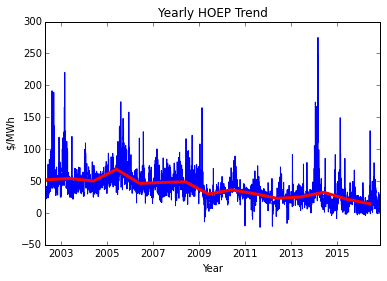

Year
2002    51.997893
2003    54.045418
2004    49.949662
2005    68.492054
2006    46.383076
2007    47.806318
2008    48.829641
2009    29.517371
2010    36.253963
2011    30.151761
2012    22.804874
2013    24.978471
2014    32.388418
2015    21.663944
2016    14.358335
Name: HOEP, dtype: float64


In [4]:
daily = hoep.pivot(index='Date', columns='Hour', values='HOEP')
daily_avgs = daily.mean(axis=1)

yearly = hoep.groupby(['Year']).mean()

# print(yearly)
plt.plot(daily_avgs.index, daily_avgs)
plt.plot([pandas.to_datetime("{}-06-01".format(el)) for el in yearly.index], yearly['HOEP'], linewidth='3', color='r')
plt.title('Yearly HOEP Trend'); plt.xlabel('Year'); plt.ylabel("$/MWh"); plt.show()
print(yearly['HOEP'])


The above graph shows a downward trend in HOEP from 2002-2016, from the \$50/MWh range down to \$15/MWh in 2016. This trend may appear at first blush to indicate a decreased market price, but as we shall see the HOEP and global adjustment rate combine to drive a steady price increase.

Looking at the daily values of HOEP over the 14-year period, it is clear that there is some kind of shift in market dynamics that starts in 2009, causing a marked decrease in HOEP (\$48/MWh down to \$30/MWh) as well as a change in the apparent daily / monthly fluctuations.

In [5]:
hoep_pre_change = hoep[hoep['Year'] <  2009]
hoep_post_change = hoep[hoep['Year'] > 2009]

print("HOEP pre-2009 standard deviation: ",np.std(hoep_pre_change['HOEP']))
print("HOEP post-2009 standard deviation: ",np.std(hoep_post_change['HOEP']))

print("HOEP pre-2009 mean: ",np.mean(hoep_pre_change['HOEP']))
print("HOEP post-2009 mean: ",np.mean(hoep_post_change['HOEP']))


HOEP pre-2009 standard deviation:  32.9870756122
HOEP post-2009 standard deviation:  30.380697276
HOEP pre-2009 mean:  52.5227800574
HOEP post-2009 mean:  26.2850422801


The above calculations show a signficant difference in the mean HOEP before/after 2009 as well as a small change in standard deviation, indicating that the is a subtle change in the dynamics of the market post 2009. Given this, we should create predictions of future market behaviour based on post-2009 data and ignore the older information which may represent a different market structure or market force. 

## Global Adjustment Trend ##

Although the HOEP has been on a downward trend, this energy price is more than offset by an increasing global adjustment (GA) rate. From 2005 through 2016, the GA roughly mirrors the decline in HOEP market pricing for electricity, and leading to an overall increase in GA expenditure on a per-MWh basis.

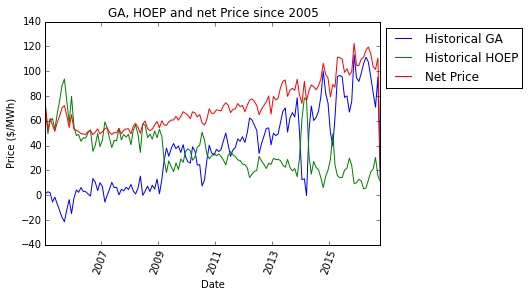

             GA       HOEP       price       Date    change
Year                                                       
2005  -7.444167  69.464032   62.019865 2005-06-01       NaN
2006   4.551667  46.368078   50.919744 2006-06-01 -0.178977
2007   4.025833  47.872798   51.898631 2007-06-01  0.019224
2008   6.150833  48.880905   55.031738 2008-06-01  0.060370
2009  31.191667  29.580886   60.772553 2009-06-01  0.104318
2010  27.625000  36.226828   63.851828 2010-06-01  0.050669
2011  40.500000  30.174399   70.674399 2011-06-01  0.106850
2012  49.716667  22.791225   72.507892 2012-06-01  0.025943
2013  59.691667  24.969335   84.661001 2013-06-01  0.167611
2014  56.377500  32.650972   89.028472 2014-06-01  0.051588
2015  79.180833  21.842448  101.023281 2015-06-01  0.134730
2016  87.126000  14.402411  101.528411 2016-06-01  0.005000
Avg annual price change, 2005-2016: 4.98%


In [22]:
ga = pandas.read_csv("global_adjustment.csv",encoding = 'latin1')
ga['Date'] = [pandas.Timestamp("{}-{}".format(y,m)) for y,m in zip(ga['Year'], ga['Month'])]
ga['Date'] = pandas.to_datetime(ga['Date'])
ga.sort('Date', inplace=True)
ga['YrMo'] = ["{}-{:02d}".format(date.year, date.month) for date in ga['Date']]
ga = ga.set_index('YrMo')

hoep_now = hoep[hoep['Date'] > min(ga['Date'])];
hoep_now['YrMo'] = ["{}-{:02d}".format(date.year, date.month) for date in hoep_now['Date']]

hoep_now = hoep_now.groupby('YrMo').mean()

price = ga.copy()
price['HOEP'] = hoep_now['HOEP']
price['price'] = price['GA'] + price['HOEP']

yearly = price.groupby('Year').mean()
yearly['Date'] = [pandas.Timestamp("{}-{}-{}".format(el, 6,1) ) for el in yearly.index]
yearly['change'] = yearly.price.pct_change()

plt.plot(price['Date'], price['GA'], label="Historical GA")
plt.plot(price['Date'], price['HOEP'], label="Historical HOEP")
plt.plot(price['Date'], price['price'], label="Net Price", color='r')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel('Date'); plt.ylabel('Price ($/MWh)'); plt.title('GA, HOEP and net Price since 2005')
plt.xticks(rotation=70); plt.show()

print(yearly)
print("Avg annual price change, 2005-2016: {:.2f}%".format(yearly.change.mean()*100))






The above table shows a yearly summary of the market prices and global adjustment over the past 10 years. The average price growth has been nearly 6% over this period, accounting for both GA and HOEP trends. If this trend continues, there will be significant value in a net-metering PPA with sub-5% price escalation.


We can model these pricing trends using 2nd degree polynomials to get a standardized number for current GA, HOEP and net price values that filters out short-term fluctuation; the trendlines for each graph are shown below.

Residual Error - GA: [ 32162.38638072]
Residual Error - HOEP: [ 19201.02027073]
Residual Error - Net: [ 13164.57117522]
Current GA: 90.42443542959387
Current HOEP:19.93843566965579
Current Price: 110.3628710992497


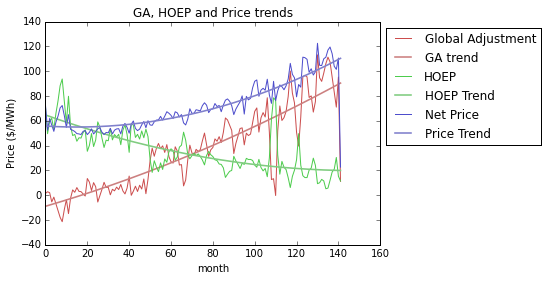

In [7]:



index = list(range(0,len(price['GA']), 1))

coeffs, residual, _, _,_ = np.polyfit(index, price['GA'], 2, full=True)
p_ga = np.poly1d(coeffs)
print("Residual Error - GA: {}".format(residual))


coeffs, residual, _, _,_ = np.polyfit(index, price['HOEP'], 2, full=True)
p_hoep = np.poly1d(coeffs)
print("Residual Error - HOEP: {}".format(residual))

coeffs, residual, _, _,_ = np.polyfit(index, price['price'], 2, full=True)
p_price = np.poly1d(coeffs)
print("Residual Error - Net: {}".format(residual))

plt.plot(index, price['GA'], label='Global Adjustment', color=(0.8,0.3,0.3))
plt.plot(index, p_ga(index), label='GA trend',color=(0.8,0.5,0.5), linewidth=1.6)

plt.plot(index, price['HOEP'], label='HOEP', color=(0.3,0.8,0.3))
plt.plot(index,p_hoep(index), label='HOEP Trend', color=(0.5,0.8,0.5), linewidth=1.6)

plt.plot(index, price['price'], label='Net Price', color=(0.3,0.3,0.8))
plt.plot(index,p_price(index), label='Price Trend', color=(0.5,0.5,0.8), linewidth=1.6)
plt.xlabel("month"); plt.ylabel("Price ($/MWh)")
plt.title("GA, HOEP and Price trends");
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

current_GA = p_ga(index[-1])
current_HOEP = p_hoep(index[-1])
current_price = p_price(index[-1])
print("Current GA: {}".format(current_GA))
print("Current HOEP:{}".format(current_HOEP))
print("Current Price: {}".format(current_price))


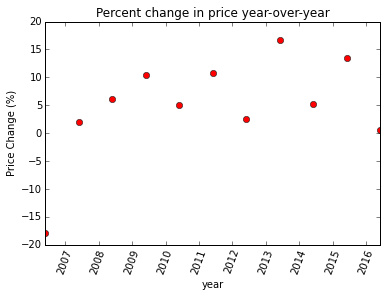

In [8]:
plt.plot(yearly['Date'], yearly.change*100, 'ro')
plt.xlabel('year'); plt.ylabel('Price Change (%)')
plt.xticks(rotation=70)
plt.title('Percent change in price year-over-year'); plt.show()


## Daily Profiles ##

Now lets look at the daily average price profile. The goal of this analysis is to identify how the hourly spot market changes throught a typical day, whether that pattern is changing over time, and what implications it has for the value of solar generated during the day as compared to the 24-hr average spot price for energy.


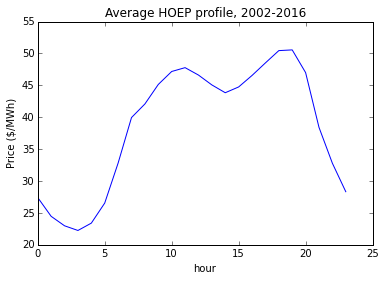

In [9]:
def day_profile(df, name="Daily Profile", show=True):
    daily = df.pivot(index='Date', columns='Hour', values='HOEP').mean(axis=0)
    
    if show:
        plt.plot(daily)
        plt.title(name)
        plt.xlabel("hour")
        plt.ylabel("Price ($/MWh)")
        
    return daily

day_profile(hoep, name='Average HOEP profile, 2002-2016');






The blended hourly profile across 2002-2016 is shown above. This profile shows that there is a significant peak in price between 900 and 2100 hrs, which correlates well with the solar output we enjoy. However, there is a lot of year-to-year fluctuation that is hidden in this graph - as we saw with the year-over-year average HOEP prices above, there is a slow decrease in price as well as a change in market dynamics that occurs around 2009. In the next graph we break down the average profile by year and graph them together in 3D, giving an idea of how the profile changes through the years.


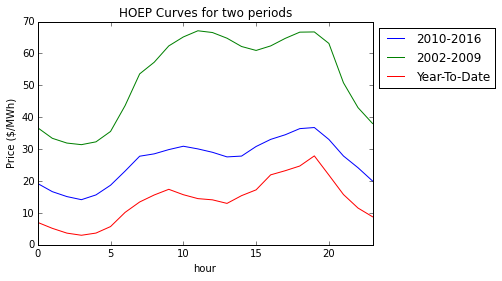

In [10]:
hoep_2010 = hoep[hoep['Year']>=2010].pivot(index='Date', columns='Hour', values='HOEP').mean(axis=0)
hoep_2002 = hoep[hoep['Year']< 2009].pivot(index='Date', columns='Hour', values='HOEP').mean(axis=0)

mrd = hoep['Date'].max()
start_date = pandas.Timestamp("{}-{:02d}-{:02d}".format(mrd.year-1, mrd.month, mrd.day-1))
this_yr = hoep[hoep['Date'] > start_date]
this_yr_profile = this_yr.pivot(index='Date', columns='Hour', values='HOEP').mean(axis=0)

plt.plot(hoep_2010, label="2010-2016")
plt.plot(hoep_2002, label="2002-2009")
plt.plot(this_yr_profile, label="Year-To-Date")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.title("HOEP Curves for two periods"); plt.xlim(0,23)
plt.xlabel("hour"); plt.ylabel("Price ($/MWh)"); plt.show()





The above graph shows daily price profiles for the pre-2009 period, the post-2009 period and the past year. These profiles illustrate a significant drop in HOEP averages over the time period. 

By graphing these curves as a percent of mean, we can see how the profile changes over the years. We can observe a shift from a late-morning peak in the pre-2009 period to a late-day peak in the post-2010 period, which is particularly accentuated in the year-to-date profile - as graphed below:


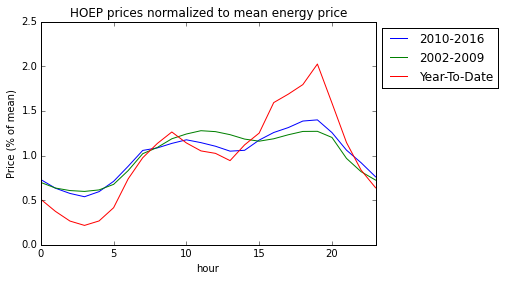

In [11]:
plt.plot(hoep_2010/hoep_2010.mean(), label="2010-2016")
plt.plot(hoep_2002/hoep_2002.mean(), label="2002-2009")
plt.plot(this_yr_profile/this_yr_profile.mean(), label="Year-To-Date")
plt.legend(loc="upper left", bbox_to_anchor=(1,1)); plt.xlim(0,23)
plt.title("HOEP prices normalized to mean energy price")
plt.xlabel("hour"); plt.ylabel("Price (% of mean)"); plt.show()

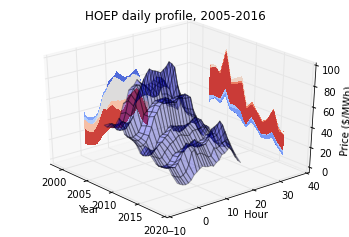

In [12]:
daily_yoy = hoep.pivot(index='Date', columns='Hour', values='HOEP')
daily_yoy['Year'] = [el.year for el in daily_yoy.index]
profiles = daily_yoy.groupby('Year').mean()

from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')

X,Y = np.meshgrid(profiles.index, profiles.columns)
Z = np.array(profiles).transpose()

ax.plot_surface(X,Y,Z, rstride=1, cstride=1, alpha=0.3)

cset = ax.contourf(X, Y, Z, zdir='z', offset=-100, cmap=cm.coolwarm)
cset = ax.contourf(X, Y, Z, zdir='x', offset=1998, cmap=cm.coolwarm)
cset = ax.contourf(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)

ax.set_xlabel("Year"); ax.set_xlim(1998,2020)
ax.set_ylabel("Hour"); ax.set_ylim(-10,40)
ax.set_zlabel("Price ($/MWh)"); ax.set_zlim(-3,100)
ax.set_title("HOEP daily profile, 2005-2016")
ax.view_init(30,-40)




The above graph shows in more detail the shift that is evident around the 2009 time-period where HOEP prices changed. 

Looking at the daily profiles in the below graph, we see that steady progression to lower market prices and a skewing of the profile towards evening consumption peaks.

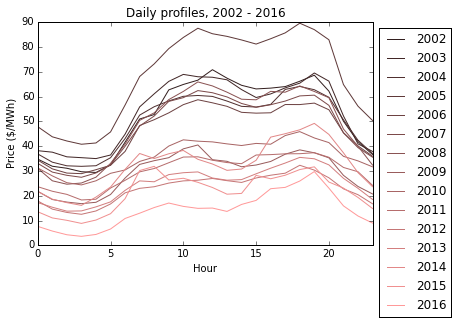

In [13]:
color = np.linspace(0.2, 1, len(profiles))
for el, red in zip(profiles.iterrows(), color):
    plt.plot(el[1], label=el[0], color=(red,red*0.6,red*0.6))

plt.legend(loc="upper left", bbox_to_anchor=(1,1)); plt.xlim(0,23)
plt.title('Daily profiles, 2002 - 2016')
plt.xlabel('Hour'); plt.ylabel('Price ($/MWh)'); plt.show()

The below graph shows the same profiles normalized with respect to their own mean, showing how the profiles skew towards the evening moving through the past decade towards the present day.

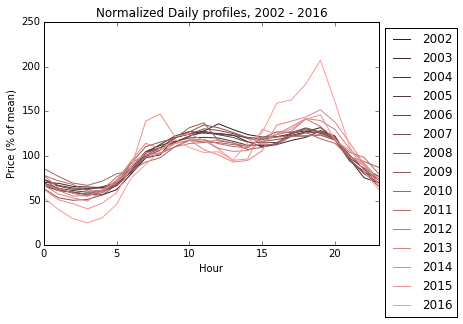

In [14]:
for el, red in zip(profiles.iterrows(), color):
    plt.plot(el[1]/np.mean(el[1])*100, label=el[0], color=(red,red*0.6,red*0.6))

plt.legend(loc="upper left", bbox_to_anchor=(1,1)); plt.xlim(0,23)
plt.title('Normalized Daily profiles, 2002 - 2016')
plt.xlabel('Hour'); plt.ylabel('Price (% of mean)')
plt.show()

The above descriptions of yearly price trends and changes in annual profile show that we need to be careful about how we model the net-metering value of solar energy. The energy profile from 2014-2016 will be the most accurate in predicting future daily consumption patterns, since these profiles reflect the change in peak price from mid-day to the evening. This profile needs to be normalized and applied to current / future market prices in order to understand the net-metering value of solar generation.

## Monthly Profile ##

The graph below shows monthly profiles aggregated from the 2010-2016 period, showing how seasonal demand patterns might influence the shape of the demand profile. Of particular note is that the pattern of consumption in January - March includes a much higher early-morning energy spike, most likely reflecting increased heating and lighting requirements during darker and colder winter days. Comparing the mean profile across this time period with the 2016 profile we can see that there is a significant downward shift in HOEP. In order to provide a load profile that incorporates more than one year of data, it will be necessary to scale the profile down so that it's mean profile matches the present HOEP prices.

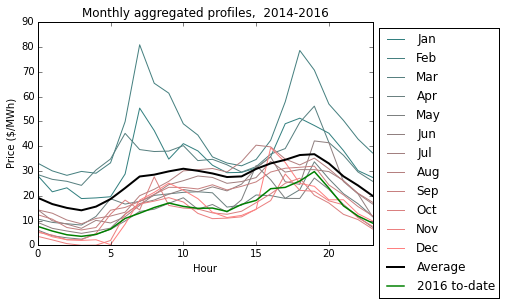

In [15]:
start_year = 2014

monthly = hoep[hoep['Year'] >= start_year].pivot(index='Date', columns='Hour', values='HOEP')
monthly['YrMo'] = ["{}.{:02d}".format(el.year, el.month) for el in monthly.index]
monthly['Month'] = [el.month for el in monthly.index]
monthly = monthly.groupby('Month').mean()

# print(monthly)

months = ["", 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

colors = np.linspace(0.2, 1, 12)
for row, intensity in zip(monthly.iterrows(), colors):
    plt.plot(row[1], label=months[int(row[0])], color=(intensity, 0.5,0.5))

plt.plot(hoep_2010, label="Average", color='k', linewidth=2)
plt.plot(profiles[profiles.index==2016].transpose(), label='2016 to-date', color='g', linewidth=1.5)
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

plt.title("Monthly aggregated profiles,  {}-2016".format(start_year))
plt.xlabel('Hour'); plt.ylabel('Price ($/MWh)'); plt.xlim(0,23); plt.show()




In [16]:
print(monthly.mean(axis=1))

Month
1        34.286868
2        46.148603
3        35.335887
4        17.928079
5        14.395327
6        20.054991
7        21.219713
8        24.320148
9        19.738829
10       13.914601
11       12.398902
12       15.116640
dtype: float64


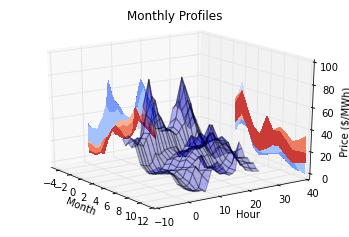

In [17]:
fig = plt.figure()
ax = fig.gca(projection='3d')

X,Y = np.meshgrid(monthly.index, monthly.columns)
Z = np.array(monthly).transpose()

ax.plot_surface(X,Y,Z, rstride=1, cstride=1, alpha=0.3)

cset = ax.contourf(X, Y, Z, zdir='z', offset=-100, cmap=cm.coolwarm)
cset = ax.contourf(X, Y, Z, zdir='x', offset=-5, cmap=cm.coolwarm)
cset = ax.contourf(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)

ax.set_xlim(-5,12);   ax.set_xlabel("Month")
ax.set_ylim(-10,40);  ax.set_ylabel("Hour")
ax.set_zlim(-3,100);  ax.set_zlabel("Price ($/MWh)") 
ax.set_title('Monthly Profiles'); ax.view_init(20,-35); 


## Solar Production ##

Now we can bring in the typical solar production and see how the data compares to HOEP pricing. The heatmap below show the amount of energy produced during each hour of the day for each month in a typical year, for a 3° system in Toronto. Multiplying the energy in each hour by the average HOEP price for that hour and month gives us the total expected expenditure - dividing this result by the total energy produced gives a weighted average price for solar energy, based on a typical HOEP curve. 



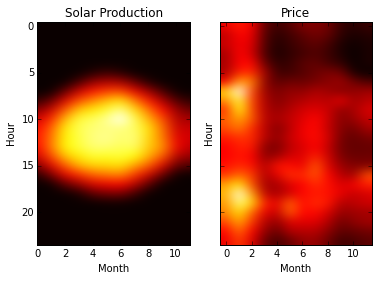

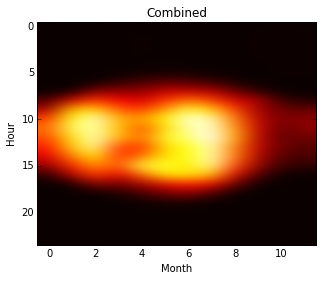

In [18]:
production = pandas.read_csv('solar-monthly-production.csv').drop('mo\\hr',1)
# print(production)
# print(monthly)



monthly_integrated = pandas.DataFrame(production.values*monthly.values)

f, (ax_prod, ax_price) = plt.subplots(1,2,sharey=True)

ax_prod.imshow(production.transpose(), cmap='hot', interpolation="bicubic")
ax_prod.set_aspect('auto'); ax_prod.set_xlabel("Month"); ax_prod.set_ylabel("Hour")
ax_prod.set_xlim([0,11]); ax_prod.set_title("Solar Production")


ax_price.imshow(monthly.transpose(), cmap='hot', interpolation="bicubic")
ax_price.set_xlabel("Month"); ax_price.set_ylabel("Hour"); 
ax_price.set_title("Price"); ax_price.set_aspect('auto')
plt.show()

plt.imshow(monthly_integrated.transpose(), cmap='hot', interpolation="bicubic",aspect=0.4)
plt.xlabel("Month"); plt.ylabel("Hour"); 
plt.title("Combined")
plt.show()

In [23]:

expenditure_total  = monthly_integrated.sum(axis=0).sum()
production_total = production.sum(axis=0).sum()

market_average_HOEP = monthly.mean(axis=0).mean()
solar_weighted_HOEP = expenditure_total / production_total

current_HOEP_solar = current_HOEP * solar_weighted_HOEP/market_average_HOEP

print("Average HOEP, 2014-present: ${:.2f} /MWh".format(market_average_HOEP))
print("Weighted HOEP value of solar, 2014-present: ${:.2f} /MWh".format(solar_weighted_HOEP))
print("Marginal HOEP multiplier: {:.0f}%".format(solar_weighted_HOEP/market_average_HOEP*100))
print("\n")




print("Market avg. price = ${:.2f} /MWh".format(current_HOEP+current_GA))
print("Solar weighted price = ${:.2f} /MWh".format(current_HOEP_solar+current_GA))
print("Marginel Price multiplier = {:.0f}%".format(100*(current_HOEP_solar+current_GA)/(current_HOEP+current_GA)))

print("Price Adder for net-metered solar: ${:0.4f}/kWh".format((current_HOEP_solar-current_HOEP)/1000))

Average HOEP, 2014-present: $22.90 /MWh
Weighted HOEP value of solar, 2014-present: $24.83 /MWh
Marginal HOEP multiplier: 108%


Market avg. price = $110.36 /MWh
Solar weighted price = $112.03 /MWh
Marginel Price multiplier = 102%
Price Adder for net-metered solar: $0.0017/kWh


The next graph shows a yearly average price curve against a yearly average solar production curve. This shows how the solar production, while being positively correlated with price (and therefore demand for energy) does not cover the whole demand cycle.

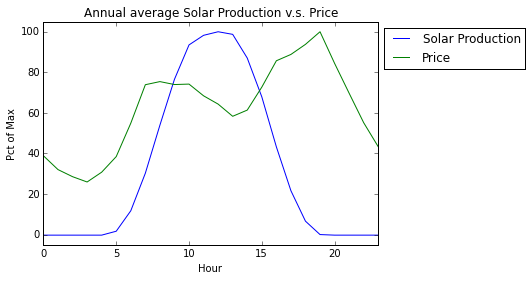

In [35]:
prod_hourly = production.mean(axis=0)
price_hourly = monthly.mean(axis=0)

plt.plot(prod_hourly/prod_hourly.max()*100, label="Solar Production")
plt.plot(price_hourly/price_hourly.max()*100, label="Price")
plt.ylabel("Pct of Max"); plt.xlabel("Hour")
plt.ylim([-5,105]); plt.xlim([0,23]); plt.title('Annual average Solar Production v.s. Price')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

plt.show()

## Discussion and Summary ##

This analysis shows the value of solar in the ontario market as being slightly above the average HOEP price that the market exhibits on a 24-hour basis. This makes perfect sense, since we know that both energy consumption and market prices are higher during the day, and that this increase in demand and price correspond roughly with a typical solar production curve. One of the primary values of solar is that can be deployed near points of consumption, and that it correlates with daily demand cycles. 

One of the challenging factors about the Ontario market is the interaction between market prices and the global adjustment. Global adjustment was introduced when merket dynamics looked very different. The market energy price comprised the vast majority of per-kWh charges that a commercial customer might face, while the GA gave policymakers a lever to adjust the average charge in order to balance total energy expenditures --- including long-standing contracts with generators. In response to falling demand for energy, electricity prices have plummeted and the global adjustment has risen in order maintain revenues required to pay contracts and attract new generation.

With the current market structure, the vast majority of what commercial customers pay for energy goes towards global adjustment charges, which are calculated on a fixed per-kWh charge that is set every month. These charges do not fluctuate with daily demand cycles, and therefore cannot be leveraged by solar. In November of 2016 the GA accounted for 82% of the average per-kWh charge, leaving only 18% of the charge to be dependant on hourly spot prices; by contrast, in 2007 the GA accounted for only 7.7% of per-kWh charges. Given this trend in pricing, the marginal value of solar as a peak production energy source is of little significance for the purpose of paying down off-peak consumption at lower rates.

Another aspect to this problem is that solar generation does not line up perfectly with demand / price curves for energy. As shown in the previous section, prices rise before solar rises, and remain high in the evening when solar production trails off, leading to a significant portion of the day where it is not meeting that demand. This mismatch in generation timing is one of the driving motivations behind the development of solar-and-storage as a method of better aligning renewable generation with demand for electricity. 

A second avenue for monetizing solar energy is to charge against potential reduced demand charges, which are based on a kW measurement of the customers instantaneous demand. These charges can be anywhere from 10-50% of a customers bill, and depend on the peak kW draw in a month. If the customer has a consistent demand spike that coincides with high power injection by the solar array, the kW peak may be reduced. However, because solar generation is not deterministic, it is very difficult to guarentee that the solar would be available at the specific time of the peak --- it could be that the peak happens during a rain-storm, or late in the day when power injection is low, in which case the entire peak would be seen by the grid and would set the rate for that month. Thus there is no guarentee that demand charges will be reduced, even though on a probabalistic basis we would expect that solar would often offset power demand. To provide a firm guarentee of reduced power draw, it is necessary to deploy a correctly-sized battery to absorb demand spikes and to shift solar energy into the peak-consumption window for the client.
This analysis shows that current net metering policies may not be enough to fully capture the value of solar energy.

More details on the global adjustment:

1. http://www.ieso.ca/documents/consult/se106/se106-20140128-Global_Adjustment_Review_Report.pdf
2. http://www.ieso.ca/Documents/Understanding_GA_Jan_2016.pdf

In [20]:
def main():


    


    daily = day_profile(hoep_file)
    daily_filtered = day_profile(hoep_filtered)
    # #
    # print(daily)
    # print(daily_filtered)
    # plt.plot(daily)
    # plt.plot(daily_filtered)

    #make a histogram of the output
    n, bins, patchs = plt.hist(hoep_file['HOEP'], 100)
    

    plt.show()
    
    daily = hoep_file.pivot(index='Date', columns='Hour', values='HOEP')

    mask = ((daily > daily.stack().quantile(0.01)) & (daily < daily.stack().quantile(0.99))).all(axis=1)
    print(mask)

    pctTrue = len([i for i in mask if i])/len(mask)
    print("{:.2f}%".format(pctTrue*100))

    # print(daily[mask])

    plt.plot(daily[mask].transpose())
    plt.plot(daily[mask].mean(axis=0), linewidth=3)

    # for profile, toPlot in zip(daily, mask):
    #     if toPlot:
    #         plt.plot(profile)

    plt.show()



    # mask = (hoep_file['HOEP'] > hoep_file['HOEP'].quantile(0.025)) & (hoep_file['HOEP'] < hoep_file['HOEP'].quantile(0.975))

    # print(mask)

    # plt.show(block=True)
    #









In [21]:
def filter(hoep, show=False):
    #sample rate is 1 sample per hour
    T = 1*60*60
    f_samp = 1/(T)
    f_ny = f_samp / 2

    #filter between 3 and 10 days
    short_days, long_days = 3, 30
    f_high=  1/(2           * 24*60*60)/f_samp
    f_low= 1/(30          * 24*60*60)/f_samp
    b =      1/(13          * 24*60*60)/f_samp
    N = int(np.ceil(12/b))
    if not N%2: N+= 1
    n = np.arange(N)


     # Compute a low-pass filter with cutoff frequency fL.
    hlpf = np.sinc(2 * f_low * (n - (N - 1) / 2.))
    hlpf *= np.blackman(N)
    hlpf /= np.sum(hlpf)

    # Compute a high-pass filter with cutoff frequency fH.
    hhpf = np.sinc(2 * f_high * (n - (N - 1) / 2.))
    hhpf *= np.blackman(N)
    hhpf /= np.sum(hhpf)
    hhpf = -hhpf
    hhpf[(N - 1) / 2] += 1

    # Add both filters.
    h = hlpf + hhpf
    # h = hhpf

    hoep_f = np.convolve(hoep, h, mode="same")

    if show:
        orig, = plt.plot(hoep)
        filt, = plt.plot(hoep_f)



        plt.legend([orig, filt], 'HOEP', 'weather-adjusted')
        plt.show(block=True)
    return hoep_f